In [7]:
from load_modules import *
import my_config

In [8]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for device in physical_devices:
        print("Device:", device)
else:
    print("No GPU devices found.")

# Set GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, False)
    except RuntimeError as e:
        print(e)

# Test for GPU device name
name = tf.test.gpu_device_name()
if name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(name))

# Print the number of available GPUs
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Found GPU at: /device:GPU:0
Num GPUs Available:  1


Load LUT data and find duplicates, select one of each set where the likeleyhood of the parameter values is the greatest

In [48]:
upper_bounds = [0.5, 0.32, 0.9, 0.9, 0.25]
lower_bounds = [0.01, 0.001, 0.2, 0.6, 0.05]

# Pair up the corresponding bounds and calculate their average
averages = [(u + l) / 2 for u, l in zip(upper_bounds, lower_bounds)]
avg_Cm, avg_Ch, avg_Bm, avg_Bh, avg_T = averages

headers = "Cm,Ch,Bm,Bh,T,sR,sG,sB,L,A,B"
lut_path1 = r"LUTs\two_hundredkLUT.csv"
lut_path2 = r"LUTs\uniform100k.csv"
lut_path3 = r"LUTs\donner_lut.csv"

df1 = pd.read_csv(lut_path1, sep=",", header=None, names=headers.split(","))
df2 = pd.read_csv(lut_path2, sep=",", header=None, names=headers.split(","))
df3 = pd.read_csv(lut_path3, sep=",", header=None, names=headers.split(","))
df = pd.concat([df1, df2, df3])
#print length of df
print(len(df))
# convert all columns to float
for column in df.columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')

#convert sR, sG, sB to int
rounded_df = df.round({'sR': 0, 'sG': 0, 'sB': 0})
# Step 1: Find duplicate RGB values
duplicates = rounded_df[rounded_df.duplicated(subset=['sR', 'sG', 'sB'], keep=False)].copy() # added .copy()


# Step 2: Calculate the 'likelihood' score for each row
duplicates['likelihood'] = (abs(duplicates['Cm'] - avg_Cm) +
                            abs(duplicates['Ch'] - avg_Ch) +
                            abs(duplicates['Bm'] - avg_Bm) +
                            abs(duplicates['Bh'] - avg_Bh) +
                            abs(duplicates['T'] - avg_T))

# Step 3: Sort by RGB values and likelihood, keeping the row with the lowest likelihood for each RGB group
most_likely_duplicates = duplicates.sort_values(['sR', 'sG', 'sB', 'likelihood']).drop_duplicates(subset=['sR', 'sG', 'sB'])

# Now, most_likely_duplicates should contain your desired rows

# First, remove all duplicates from the original dataframe
df_no_duplicates = df.drop_duplicates(subset=['sR', 'sG', 'sB'], keep=False)

# Concatenate df_no_duplicates with most_likely_duplicates to get the final dataframe
df = pd.concat([df_no_duplicates, most_likely_duplicates])

# If you want to sort it based on index
df.sort_index(inplace=True)
df.head()
#remove NAN columns
df = df.dropna()
df.head()
df = df[df[['sR', 'sG', 'sB', 'Cm', 'Ch', 'Bm', 'Bh', 'T']].notnull().all(axis=1)]

x = df[['sR', 'sG', 'sB']].to_numpy(dtype='float32')
y = df[['Cm', 'Ch', 'Bm', 'Bh', 'T']].to_numpy(dtype='float32')
#create new csv with headers
# df.to_csv(r'LUTs\large_no_duplicates.csv', index=False, header=True)


#train nn on x,y
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42, shuffle=True)
#remove any header values
x_train = x_train[1:]
x_test = x_test[1:]
y_train = y_train[1:]
y_test = y_test[1:]

#numpy arrays
x_train = np.asarray(x_train).reshape(-1,3).astype('float32')
x_test = np.asarray(x_test).reshape(-1,3).astype('float32')
print(f"length of df {len(df)}")
print(f"bef norm x_train[0] {x_train[0]}")

#normalize
x_train = x_train/255.0
x_test = x_test/255.0
print(f"aft norm x_train[0] {x_train[0]}")

print(f"length of x_train {len(x_train)}")
print(f"length of x_test {len(x_test)}")
print(f"length of y_train {len(y_train)}")
print(f"length of y_test {len(y_test)}")
df.head()
print(f"length of df {len(df)}")
#print random 3 rows
#print unique values of Cm,Ch,Bm,Bh,T
# print(f"unique Cm {df['Cm'].unique()}")
# print(f"unique Ch {df['Ch'].unique()}")
# print(f"unique Bm {df['Bm'].unique()}")
# print(f"unique Bh {df['Bh'].unique()}")
# print(f"unique T {df['T'].unique()}")
#as sorted lists
C_m = sorted(df['Cm'].unique())
C_h = sorted(df['Ch'].unique())
B_m = sorted(df['Bm'].unique())
B_h = sorted(df['Bh'].unique())
T = sorted(df['T'].unique())
print(f"Cm = {C_m}")
print(f"Ch = {C_h}")
print(f"Bm = {B_m}")
print(f"Bh = {B_h}")
print(f"T = {T}")
#min max for each
min_vals = [min(C_m), min(C_h), min(B_m), min(B_h), min(T)]
max_vals = [max(C_m), max(C_h), max(B_m), max(B_h), max(T)]
print(f"upper bounds = {max_vals}")
print(f"lower bounds = {min_vals}")
#integer arrays for sR,sG,sB 0 to 255
# Assuming df is your DataFrame and it has columns 'sR', 'sG', 'sB'
df[['sR', 'sG', 'sB']] = df[['sR', 'sG', 'sB']].astype(float)
df[['sR', 'sG', 'sB']] = df[['sR', 'sG', 'sB']].applymap(np.round)
# Add a 'count' column that counts the number of identical RGB values
df['count'] = df.groupby(['sR', 'sG', 'sB'])['sR'].transform('count')
print(f"number of repeated RGB values {len(df[df['count'] > 1])}")

C:\Users\joeli\AppData\Local\Temp\ipykernel_17348\2286786837.py:13: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(lut_path1, sep=",", header=None, names=headers.split(","))
C:\Users\joeli\AppData\Local\Temp\ipykernel_17348\2286786837.py:14: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv(lut_path2, sep=",", header=None, names=headers.split(","))
C:\Users\joeli\AppData\Local\Temp\ipykernel_17348\2286786837.py:15: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv(lut_path3, sep=",", header=None, names=headers.split(","))


402128
length of df 69039
bef norm x_train[0] [137.  79.  86.]
aft norm x_train[0] [0.5372549  0.30980393 0.3372549 ]
length of x_train 62134
length of x_test 6903
length of y_train 62134
length of y_test 6903
length of df 69039
Cm = [0.0, 0.0002, 0.0008, 0.001, 0.002, 0.0038, 0.0066, 0.008, 0.0105, 0.0156, 0.0222, 0.027, 0.0305, 0.0406, 0.0527, 0.0639, 0.067, 0.0837, 0.103, 0.1249, 0.125, 0.1499, 0.178, 0.2093, 0.2158, 0.2441, 0.2826, 0.325, 0.3427, 0.3713, 0.4219, 0.4768, 0.5115, 0.5364, 0.6007, 0.6699, 0.7283, 0.7443, 0.824, 0.9091, 0.999, 1.0]
Ch = [0.0, 0.0002, 0.0008, 0.001, 0.0019, 0.0039, 0.0052, 0.0072, 0.0123, 0.0169, 0.0198, 0.0301, 0.0417, 0.0441, 0.0625, 0.0861, 0.087, 0.1158, 0.1526, 0.162, 0.1975, 0.2517, 0.2775, 0.3164, 0.3928, 0.4458, 0.4823, 0.5862, 0.681, 0.7061, 0.8435, 0.999, 1.0]
Bm = [0.0, 0.1111, 0.1667, 0.2222, 0.3333, 0.4444, 0.5, 0.5556, 0.6667, 0.7778, 0.8333, 0.8889, 1.0]
Bh = [0.0, 0.1111, 0.2222, 0.25, 0.3333, 0.4444, 0.5, 0.5556, 0.6667, 0.75, 0.7778, 0.

In [9]:

# np.random.seed(42)
# #load csv
# headers = "Cm,Ch,Bm,Bh,T,sR,sG,sB,L,A,B"
# lut_path1 = r"LUTs\two_hundredkLUT.csv"
# lut_path2 = r"LUTs\uniform100k.csv"
# df1 = pd.read_csv(lut_path1, sep=",", header=None, names=headers.split(","))
# #drop header
# df1 = df1[1:]
# df2 = pd.read_csv(lut_path2, sep=",", header=None, names=headers.split(","))
# df = pd.concat([df1])
# df = df.drop_duplicates()
# #print length of df
# print(f"length of df {len(df)}")
# df['T'] = pd.to_numeric(df['T'], errors='coerce')
# df['Cm'] = pd.to_numeric(df['Cm'], errors='coerce')
# df['Ch'] = pd.to_numeric(df['Ch'], errors='coerce')
# df['Bh'] = pd.to_numeric(df['Bh'], errors='coerce')
# df['Bm'] = pd.to_numeric(df['Bm'], errors='coerce')
# # Drop rows where 'T' > 0.26
# # df = df[df['T'] <= 0.3]
# #drop cm < 0.001 and cm > 0.5
# # df = df[df['Cm'] >= 0.001]
# # df = df[df['Ch'] >= 0.001]
# #drop rows with Bh > 0.5
# # df = df[df['Bh'] >= 0.25]
# df.drop(df.index[0], inplace=True)
# print(f"length of df {len(df)}")
# # Filter out non-numeric rows
# def is_numeric(string):
#     try:
#         float(string)
#         return True
#     except ValueError:
#         return False
# #save as new csv
# name = "donner_lut.csv"
# #write header
# df.to_csv(name, index=False)
# x = df[['sR', 'sG', 'sB']].applymap(is_numeric)
# x = df[x.all(axis=1)][['sR', 'sG', 'sB']].to_numpy(dtype='float32')
# #convert from sRGB255 to sRGB1
# y = df[['Cm', 'Ch', 'Bm', 'Bh', 'T']].applymap(is_numeric)
# y = df[y.all(axis=1)][['Cm', 'Ch', 'Bm', 'Bh', 'T']].to_numpy(dtype='float32')
# df.head()
# #train nn on x,y
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42, shuffle=True)
# #remove any header values
# x_train = x_train[1:]
# x_test = x_test[1:]
# y_train = y_train[1:]
# y_test = y_test[1:]

# #numpy arrays
# x_train = np.asarray(x_train).reshape(-1,3).astype('float32')
# x_test = np.asarray(x_test).reshape(-1,3).astype('float32')
# print(f"length of df {len(df)}")
# print(f"bef norm x_train[0] {x_train[0]}")

# #normalize
# x_train = x_train/255.0
# x_test = x_test/255.0
# print(f"aft norm x_train[0] {x_train[0]}")

# print(f"length of x_train {len(x_train)}")
# print(f"length of x_test {len(x_test)}")
# print(f"length of y_train {len(y_train)}")
# print(f"length of y_test {len(y_test)}")
# df.head()
# print(f"length of df {len(df)}")
# #print random 3 rows
# #print unique values of Cm,Ch,Bm,Bh,T
# # print(f"unique Cm {df['Cm'].unique()}")
# # print(f"unique Ch {df['Ch'].unique()}")
# # print(f"unique Bm {df['Bm'].unique()}")
# # print(f"unique Bh {df['Bh'].unique()}")
# # print(f"unique T {df['T'].unique()}")
# #as sorted lists
# C_m = sorted(df['Cm'].unique())
# C_h = sorted(df['Ch'].unique())
# B_m = sorted(df['Bm'].unique())
# B_h = sorted(df['Bh'].unique())
# T = sorted(df['T'].unique())
# print(f"Cm = {C_m}")
# print(f"Ch = {C_h}")
# print(f"Bm = {B_m}")
# print(f"Bh = {B_h}")
# print(f"T = {T}")
# #min max for each
# min_vals = [min(C_m), min(C_h), min(B_m), min(B_h), min(T)]
# max_vals = [max(C_m), max(C_h), max(B_m), max(B_h), max(T)]
# print(f"upper bounds = {max_vals}")
# print(f"lower bounds = {min_vals}")
# #integer arrays for sR,sG,sB 0 to 255
# # Assuming df is your DataFrame and it has columns 'sR', 'sG', 'sB'
# df[['sR', 'sG', 'sB']] = df[['sR', 'sG', 'sB']].astype(float)
# df[['sR', 'sG', 'sB']] = df[['sR', 'sG', 'sB']].applymap(np.round)
# # Add a 'count' column that counts the number of identical RGB values
# df['count'] = df.groupby(['sR', 'sG', 'sB'])['sR'].transform('count')
# print(f"number of repeated RGB values {len(df[df['count'] > 1])}")

C:\Users\joeli\AppData\Local\Temp\ipykernel_17348\14674448.py:7: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(lut_path1, sep=",", header=None, names=headers.split(","))
C:\Users\joeli\AppData\Local\Temp\ipykernel_17348\14674448.py:10: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv(lut_path2, sep=",", header=None, names=headers.split(","))


length of df 180320
length of df 180319
length of df 180319
bef norm x_train[0] [217.585 171.161 127.47 ]
aft norm x_train[0] [0.8532745  0.6712196  0.49988237]
length of x_train 162286
length of x_test 18031
length of y_train 162286
length of y_test 18031
length of df 180319
Cm = [0.0, 0.0002, 0.0008, 0.002, 0.0038, 0.0066, 0.0105, 0.0156, 0.0222, 0.0305, 0.0406, 0.0527, 0.067, 0.0837, 0.103, 0.125, 0.1499, 0.178, 0.2093, 0.2441, 0.2826, 0.325, 0.3713, 0.4219, 0.4768, 0.5364, 0.6007, 0.6699, 0.7443, 0.824, 0.9091, 1.0]
Ch = [0.0, 0.0002, 0.0008, 0.0019, 0.0039, 0.0072, 0.0123, 0.0198, 0.0301, 0.0441, 0.0625, 0.0861, 0.1158, 0.1526, 0.1975, 0.2517, 0.3164, 0.3928, 0.4823, 0.5862, 0.7061, 0.8435, 1.0]
Bm = [0.0, 0.1667, 0.3333, 0.5, 0.6667, 0.8333, 1.0]
Bh = [0.0, 0.25, 0.5, 0.75, 1.0]
T = [0.05, 0.1167, 0.1833, 0.25, 0.3167, 0.3833, 0.45]
upper bounds = [1.0, 1.0, 1.0, 1.0, 0.45]
lower bounds = [0.0, 0.0, 0.0, 0.0, 0.05]
number of repeated RGB values 126954


In [50]:
np.random.seed(7)
BATCH_SIZE = 1024
# upper_bounds = [0.5, 0.32, 0.9, 0.9, 0.25]
# lower_bounds = [0.01, 0.001, 0.2, 0.6, 0.05]
NUM_NEURONS = 75
NUM_LAYERS = 2
NUM_EPOCHS = 200
LR = 1e-3
MLR = 1e-6
about_string = f"batch_size_{BATCH_SIZE}_neurons_{NUM_NEURONS}_layers_{NUM_LAYERS}_epochs_{NUM_EPOCHS}_lr_{LR}_mlr_{MLR}_upper_bounds_{upper_bounds}_lower_bounds_{lower_bounds}"

def decoder():
    input = Input(shape=(5,), name="decoder_input")
    for i in range(NUM_LAYERS):
        if i == 0:
            x = Dense(NUM_NEURONS, activation='relu', name=f"decoder_dense_{i+1}")(input)
        else:
            x = Dense(NUM_NEURONS, activation='relu', name=f"decoder_dense_{i+1}")(x)
    out = Dense(3, name="encoder_output")(x)
    model = Model(inputs=input, outputs=out, name='decoder')
    return model

def encoder():
    input = Input(shape=(3,),name="encoder_input")
    for i in range(NUM_LAYERS):
        if i == 0:
            x = Dense(NUM_NEURONS, activation='relu', name=f"encoder_dense_{i+1}")(input)
        else:
            x = Dense(NUM_NEURONS, activation='relu', name=f"encoder_dense_{i+1}")(x)
    out = Dense(5, name="decoder_output")(x)
    model = Model(inputs=input, outputs=out, name = 'encoder')
    return model
def autoencoder(encoder, decoder):
    input_end_to_end = Input(shape=(3,))
    l1 = encoder(input_end_to_end)
    l2 = decoder(l1)
    input_list = [encoder.input, decoder.input, input_end_to_end]
    output_list = [encoder.output, decoder.output, l2]
    model = Model(inputs=input_list, outputs=output_list, name = 'autoencoder')
    return model
encoder = encoder()
decoder = decoder()
autoencoder = autoencoder(encoder, decoder)
print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())

def albedo_loss(y_true, y_pred):
    #l1 norm
    l1_norm = K.sum(K.abs(y_pred - y_true), axis=-1)
    return l1_norm

def parameter_loss(y_true, y_pred):
    #l2 norm
    l2_norm = K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))
    lower_bound_mask = tf.math.less(y_pred, lower_bounds)
    upper_bound_mask = tf.math.greater(y_pred, upper_bounds)
    out_of_range_mask = tf.logical_or(lower_bound_mask, upper_bound_mask)
    out_of_range_mask = tf.cast(out_of_range_mask, tf.float32)*(0.1/BATCH_SIZE)
    # # Apply a penalty for out of range values)
    out_of_range_penalty = tf.reduce_sum(tf.cast(out_of_range_mask, tf.float32))
    # negative_penalty = tf.reduce_sum(tf.cast(tf.math.less(y_pred, 0.0), tf.float32)) #penalty for negative values ie ypred [-0.01,0,0,0,0] = tf.reduce_sum(tf.cast(tf.math.less(y_pred, 0.0), tf.float32))/5.0 = 0.2
    return l2_norm + out_of_range_penalty
def end_to_end_loss(y_true, y_pred):
    #l1 norm
    l1_norm = K.sum(K.abs(y_pred - y_true), axis=-1)
    return l1_norm


# # Compile the autoencoder with the custom loss function and optimizer
autoencoder.compile(optimizer='adam', loss=[parameter_loss, albedo_loss, end_to_end_loss], loss_weights=[.3,.1, .6])
# autoencoder.compile(optimizer='adam', loss=[parameter_loss, albedo_loss, end_to_end_loss], loss_weights=[.6,.1,.3])
# 0.2, 0.1, 0.7
# autoencoder.compile(optimizer='adam', loss=[parameter_loss, albedo_loss, end_to_end_loss], loss_weights=[.1,.1,.8])


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 3)]               0         
_________________________________________________________________
encoder_dense_1 (Dense)      (None, 75)                300       
_________________________________________________________________
encoder_dense_2 (Dense)      (None, 75)                5700      
_________________________________________________________________
decoder_output (Dense)       (None, 5)                 380       
Total params: 6,380
Trainable params: 6,380
Non-trainable params: 0
_________________________________________________________________
None
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 5)]               0         
___________________________________

In [51]:
checkpoint = ModelCheckpoint(r"C:\Users\joeli\OneDrive\Documents\GitHub\AutoEncoder_Integrated\autoencoder_best.h5py", monitor='loss', verbose=0,
    save_best_only=True, mode='auto', period=200)
adjust_lr = ReduceLROnPlateau(monitor='loss', factor=0.01, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=MLR, lr=LR)
# Define the Keras TensorBoard callback.

logdir=r"C:\Users\joeli\OneDrive\Documents\GitHub\AutoEncoder_Integrated\tensorboard_log_dir"
# tensorboard_callback = tf.keras.callbacks.TensorBoard(filepath=logdir, save_weights_only = True,save_freq = 100,verbose = 1)
print_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: print(f"epoch: {epoch} , {logs}") if epoch % 25 == 0 else None)

callbacks = [
    checkpoint,
    adjust_lr,
    print_callback
]
with tf.device('/device:GPU:0') as device:
    #show device name
    print(device)
    #ae_in: enc_in, dec_in, end_to_end_in
    x = [x_train, y_train,x_train]
     #ae_out: enc_out, dec_out, end_to_end_out
    x_val = [x_test, y_test,x_test]
    #outputs: encoder, decoder, autoencoder
    y = [y_train,x_train,x_train]
    y_val = [y_test,x_test,x_test]
    autoencoder.fit(x,y, epochs=200, batch_size=BATCH_SIZE, shuffle=True, validation_data=(x_val, y_val), callbacks=callbacks,verbose=0)

       

None
epoch: 0 , {'loss': 0.6406342387199402, 'decoder_output_loss': 1.1041975021362305, 'encoder_output_loss': 0.6977508068084717, 'decoder_loss': 0.3993329405784607, 'val_loss': 0.36094018816947937, 'val_decoder_output_loss': 0.8131681084632874, 'val_encoder_output_loss': 0.5822614431381226, 'val_decoder_loss': 0.09793929755687714, 'lr': 0.001}
epoch: 25 , {'loss': 0.18487267196178436, 'decoder_output_loss': 0.5550031065940857, 'encoder_output_loss': 0.11172531545162201, 'decoder_loss': 0.01199874933809042, 'val_loss': 0.1855555921792984, 'val_decoder_output_loss': 0.5512686967849731, 'val_encoder_output_loss': 0.10986911505460739, 'val_decoder_loss': 0.015313439071178436, 'lr': 0.001}
epoch: 50 , {'loss': 0.18000183999538422, 'decoder_output_loss': 0.5560985803604126, 'encoder_output_loss': 0.09969006478786469, 'decoder_loss': 0.005338700022548437, 'val_loss': 0.17815977334976196, 'val_decoder_output_loss': 0.5499933958053589, 'val_encoder_output_loss': 0.09985055029392242, 'val_deco

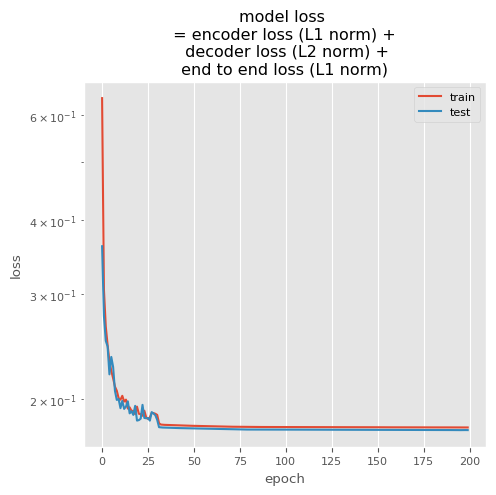

In [58]:
# # Plot the loss function
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
#add tick labels
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
#ggplot style
plt.style.use('ggplot')
plt.figure(figsize=(5,5))
#fontsize 16
plt.rcParams.update({'font.size': 8})
plt.plot(autoencoder.history.history['loss']) 
plt.plot(autoencoder.history.history['val_loss'])
plt.title('model loss \n = encoder loss (L1 norm) + \n decoder loss (L2 norm) +\n end to end loss (L1 norm) ')
plt.ylabel('loss')
plt.yscale('log')
plt.xlabel('epoch')
plt.yticks
# plt.xlim(-1,50)
plt.tight_layout()
plt.legend(['train', 'test'], loc='upper right')
#show tick labels
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.show()




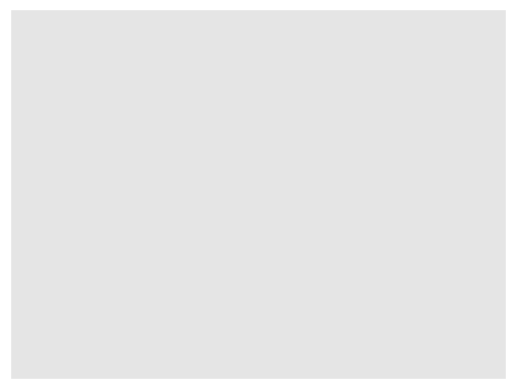

In [53]:
WIDTH = HEIGHT = 4096
plt.xticks([])
plt.yticks([])
def encode(img):
    image = np.asarray(img).reshape(-1,3).astype('float32')
    # pred_maps = encoder.predict(image)
    start = time.time()
    with tf.device('/device:GPU:0') as device:
        pred_maps = encoder.predict_on_batch(image)
    end = time.time()
    elapsed = end - start
    return pred_maps, elapsed
 
def decode(encoded):
    # recovered = decoder.predict(encoded)
    start = time.time()
    with tf.device('/device:GPU:0') as device:
        #lower batch size to 2048
        recovered = decoder.predict_on_batch(encoded)
        # recovered = decoder.predict_on_batch(encoded)
    end = time.time()
    elapsed = end - start
    recovered = np.clip(recovered, 0, 1)
    
    return recovered, elapsed
def calculate_deltaE(original, recovered):  # assuming this function is defined
# Convert the images to the CAM02-UCS color space and calculate the delta E loss
    original = np.array(original)
    recovered = np.array(recovered)
    if original.shape[0] != WIDTH or original.shape[1] != HEIGHT:
        original = original.reshape((WIDTH,HEIGHT,3))
    if recovered.shape[0] != WIDTH or recovered.shape[1] != HEIGHT:
        recovered = recovered.reshape((WIDTH,HEIGHT,3))
    if np.max(original) > 1.5:
        original = original/255
    if np.max(recovered) > 1.5:
        recovered = recovered/255
    original_lab = colorspacious.cspace_convert(np.array(original), 'sRGB1', 'CAM02-UCS')
    recovered_lab = colorspacious.cspace_convert(np.array(recovered), 'sRGB1', 'CAM02-UCS')
    delta_e = np.sqrt(np.sum((original_lab - recovered_lab)**2, axis=2))
    if delta_e.shape[0] != WIDTH or delta_e.shape[1] != HEIGHT:
        delta_e = delta_e.reshape((WIDTH,HEIGHT))
    # Plot the delta E loss in the third subplot
    return delta_e

image_folder = my_config.IMAGE_FOLDER
image_paths = os.listdir(image_folder)


images = []
idx = 0
for image_path in image_paths:

    image_path = os.path.join(image_folder, image_path)
    image = Image.open(image_path).resize((WIDTH, HEIGHT)).convert('RGB')

    image = np.asarray(image).astype(np.uint8)/255.0
    # plt.imshow(image)
    # plt.show()
    images.append(image)
    if idx % 2 == 0:
        idx += 1
        continue
    else:
        idx += 1

subject_titles = ["A", "B", "C", "D", "E", "F", "G", "H" , "I", "J", "K", "L", "M", "N", "O", "P"]

length of test images 5
encode time: 0.582195520401001
decode time: 0.5833609104156494
cm: c_m: -0.025466950610280037, min: -0.09067060053348541, max: 0.5266836881637573, std: 0.04048514738678932, ch: c_h: 0.15528318285942078, min: -0.06259490549564362, max: 0.3612698018550873, std: 0.04139601066708565, bm: b_m: 0.563357412815094, min: 0.4360649287700653, max: 0.6224231719970703, std: 0.028076857328414917, bh: b_h: 0.5475549697875977, min: 0.38075363636016846, max: 0.7719553112983704, std: 0.03027198277413845, t: t: 0.19052644073963165, min: 0.0914558619260788, max: 0.22406068444252014, std: 0.014577238820493221
deltaE: 0.7357934007317157, min: 0.005955033243820602, max: 14.48364674838598, std: 0.7402594813416721, encode time: 0.582195520401001, decode time: 0.5833609104156494, image size: 4096x4096
encode time: 0.5417535305023193
decode time: 0.35318517684936523
cm: c_m: 0.14102984964847565, min: 0.03031618893146515, max: 0.5293675661087036, std: 0.054363835602998734, ch: c_h: 0.15571

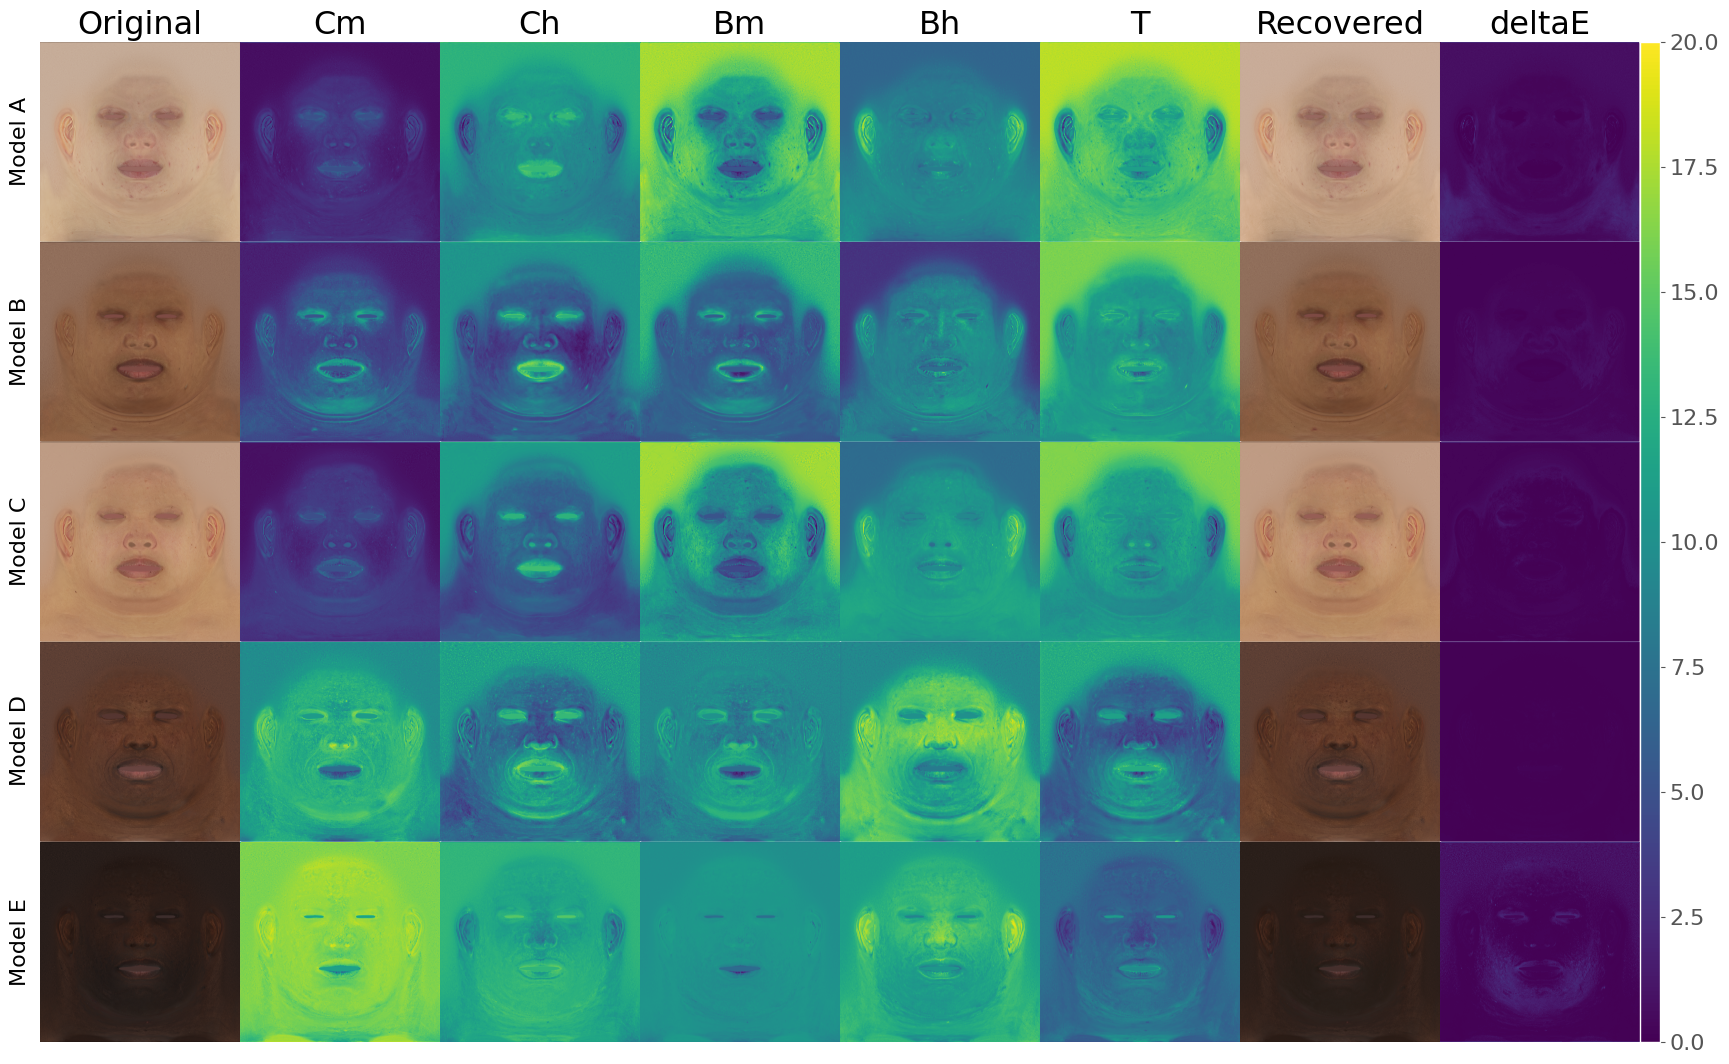

In [54]:
from matplotlib import gridspec
import time
CMAP_SPECULAR = 'viridis'

length = len(images)
rows = length
print(f"length of test images {length}")
columns = 8  # increased to 8 for original, Cm, Ch, Bm, Bh, T, Recovered, deltaE
WIDTH = HEIGHT = DIM = 4096
# create a figure with a gridspec of rows x columns
fig = plt.figure(figsize=(2*(columns+1), 2*(rows+1)))
#double the size
widths = np.ones(columns+1)
widths[-1] = 0.1
gs = gridspec.GridSpec(rows, columns+1,
                       wspace=0.0, hspace=0.0,
                       top=1.-0.5/(rows+1), bottom=0.5/(rows+1),
                       left=0.5/(columns+2), right=1-0.5/(columns+2),width_ratios=widths)  # Increase columns by 2
delta_e_strings = []
last_image = None
for i, image in enumerate(images):

    ax0 = fig.add_subplot(gs[i, 0])
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax1 = fig.add_subplot(gs[i, 1])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2 = fig.add_subplot(gs[i, 2])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax3 = fig.add_subplot(gs[i, 3])
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax4 = fig.add_subplot(gs[i, 4])
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax5 = fig.add_subplot(gs[i, 5])
    ax5.set_xticks([])
    ax5.set_yticks([])
    ax6 = fig.add_subplot(gs[i, 6])
    ax6.set_xticks([])
    ax6.set_yticks([])
    ax7 = fig.add_subplot(gs[i, 7])
    ax7.set_xticks([])
    ax7.set_yticks([])
    ax8 = fig.add_subplot(gs[:, 8])
    ax8.set_xticks([])
    ax8.set_yticks([])
    # Set the titles only for the first row
    if i == 0:
        ax0.set_title("Original")
        ax1.set_title("Cm")
        ax2.set_title("Ch")
        ax3.set_title("Bm")
        ax4.set_title("Bh")
        ax5.set_title("T")
        ax6.set_title("Recovered")
        ax7.set_title("deltaE")

    original_img = image

    image = np.asarray(image)
    image_numpy = image.reshape((WIDTH, HEIGHT, 3))
    
    
    pred_maps, encode_time = encode(image)
    print(f"encode time: {encode_time}")

    c_m = np.asarray(pred_maps[:,0])
    c_h = np.asarray(pred_maps[:,1])
    b_m = np.asarray(pred_maps[:,2])
    b_h = np.asarray(pred_maps[:,3])
    t = np.asarray(pred_maps[:,4])
    pred_maps[:,0] = c_m
    pred_maps[:,1] = c_h
    pred_maps[:,2] = b_m
    pred_maps[:,3] = b_h
    pred_maps[:,4] = t
    recovered, decode_time = decode(pred_maps)
    print(f"decode time: {decode_time}")
    recovered = np.asarray(recovered).reshape((WIDTH, HEIGHT, 3))
    

    c_m = np.asarray(pred_maps[:,0]).reshape(WIDTH, HEIGHT)
    c_h = np.asarray(pred_maps[:,1]).reshape(WIDTH, HEIGHT)
    b_m = np.asarray(pred_maps[:,2]).reshape(WIDTH, HEIGHT)
    b_h = np.asarray(pred_maps[:,3]).reshape(WIDTH, HEIGHT)
    t = np.asarray(pred_maps[:,4]).reshape(WIDTH, HEIGHT)
    #print min,mean,max of each map
    c_m_string = f"c_m: {np.mean(c_m)}, min: {np.min(c_m)}, max: {np.max(c_m)}, std: {np.std(c_m)}"
    c_h_string = f"c_h: {np.mean(c_h)}, min: {np.min(c_h)}, max: {np.max(c_h)}, std: {np.std(c_h)}"
    b_m_string = f"b_m: {np.mean(b_m)}, min: {np.min(b_m)}, max: {np.max(b_m)}, std: {np.std(b_m)}"
    b_h_string = f"b_h: {np.mean(b_h)}, min: {np.min(b_h)}, max: {np.max(b_h)}, std: {np.std(b_h)}"
    t_string = f"t: {np.mean(t)}, min: {np.min(t)}, max: {np.max(t)}, std: {np.std(t)}"
    print(f"cm: {c_m_string}, ch: {c_h_string}, bm: {b_m_string}, bh: {b_h_string}, t: {t_string}")
    
    deltaE = calculate_deltaE(image, recovered).reshape(WIDTH, HEIGHT)
    # recovered = (recovered).astype(np.uint8)
    # recovered = Image.fromarray(recovered)
    delta_e_string = f"deltaE: {np.mean(deltaE)}, min: {np.min(deltaE)}, max: {np.max(deltaE)}, std: {np.std(deltaE)}, encode time: {encode_time}, decode time: {decode_time}, image size: {WIDTH}x{HEIGHT}"
    delta_e_strings.append(delta_e_string)
    print(delta_e_string)
    #set all margins to 0
    # Replace your subplot code with this
    ax1 = fig.add_subplot(gs[i, 0])
    ax1.imshow(image)
    ax1.text(-0.15, .3, f"Model {subject_titles[i]}", fontsize=16, rotation=90, transform=ax1.transAxes)
    ax1.axis('off')
    ax1.set_aspect('equal')
    
    ax2 = fig.add_subplot(gs[i, 1])
    ax2.imshow(c_m, cmap=CMAP_SPECULAR)
    ax2.axis('off')
    ax2.set_aspect('equal')

    ax3 = fig.add_subplot(gs[i, 2])
    ax3.imshow(c_h, cmap=CMAP_SPECULAR)
    ax3.axis('off')
    ax3.set_aspect('equal')

    ax4 = fig.add_subplot(gs[i, 3])
    ax4.imshow(b_m, cmap=CMAP_SPECULAR)
    ax4.axis('off')
    ax4.set_aspect('equal')

    ax5 = fig.add_subplot(gs[i, 4])
    ax5.imshow(b_h, cmap=CMAP_SPECULAR)
    ax5.axis('off')
    ax5.set_aspect('equal')

    ax6 = fig.add_subplot(gs[i, 5])
    ax6.imshow(t, cmap=CMAP_SPECULAR)
    ax6.axis('off')
    ax6.set_aspect('equal')

    ax7 = fig.add_subplot(gs[i, 6])
    ax7.imshow(recovered)
    ax7.axis('off')
    ax7.set_aspect('equal')


    ax8 = fig.add_subplot(gs[i, 7])
    last_image = ax8.imshow(deltaE, cmap=CMAP_SPECULAR, vmin=0, vmax=20)
    ax8.axis('off')
    ax8.set_aspect('equal')
if i == rows-1:
    cbar_ax = fig.add_subplot(gs[:, -1])
    last_image = ax8.imshow(deltaE, cmap=CMAP_SPECULAR, vmin=0, vmax=20)
    fig.colorbar(last_image, cax=cbar_ax, pad=0.01)
    cbar_ax.yaxis.set_label_position('right')
    cbar_ax.set_xticks([])

#ask for user input to save the figure
save = input("Save figure? (y/n): ")
if save == "y":
    result_path = my_config.LOCAL_SAVE
    directory_name = input("Enter directory name: ")
    path = os.path.join(result_path, directory_name)
    if not os.path.exists(path):
        plt.savefig(path, dpi=500, bbox_inches='tight')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [ ]:
directory_path =  my_config.LOCAL_SAVE 
#ask user for folder name
folder_name = input("Enter folder name: ")
directory_path = os.path.join(directory_path, folder_name)
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
# Saving the models as .pb files
# tf.saved_model.save(encoder, os.path.join(directory_path, 'encoder_pb'))
# tf.saved_model.save(decoder, os.path.join(directory_path, 'decoder_pb'))
# tf.saved_model.save(autoencoder, os.path.join(directory_path, 'autoencoder_pb'))
# Saving the models as .h5 files
encoder_path = directory_path + 'encoder.h5'
decoder_path = directory_path + 'decoder.h5'
autoencoder_path = directory_path + 'ae.h5'
encoder.save(encoder_path)
decoder.save(decoder_path)
autoencoder.save(autoencoder_path)